# Ajustar un modelo a los datos

## El modelo generativo probabilístico 

Cuando se aborda un nuevo problema para ajustar un modelo a algunos datos ruidosos, el primer paso generalmente es anotar la función de probabilidad (la probabilidad de un conjunto de datos dados los parámetros del modelo). Esto es equivalente a describir el procedimiento generativo para los datos. En este caso, vamos a considerar un modelo lineal donde las incertidumbres citadas se subestiman por una cantidad fraccionaria constante. Podemos generar un conjunto de datos sintéticos de este modelo:

In [ ]:
# Importamos librerias

import emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import corner

In [10]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

x1 = np.linspace(0,10,20)
y1 = m_true * x1 + b_true


Este conjunto de datos sintéticos (con las barras de error subestimadas) tendrá un aspecto similar al siguiente:

Text(0,0.5,'y')

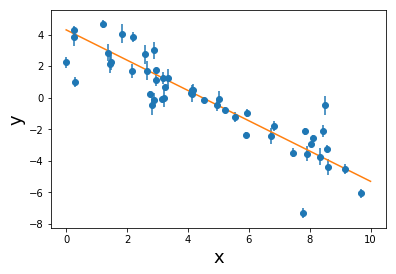

In [15]:
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(x1,y1, "-")
plt.xlabel("EJE X")
plt.ylabel("EJE Y")
plt.xlabel('x',fontsize = 18)
plt.ylabel('y',fontsize = 18)

El modelo verdadero se muestra como una línea naranja gruesa y el efecto de las incertidumbres subestimadas es obvio cuando se mira esta figura. La forma estándar de ajustar una línea a estos datos (asumiendo barras de error gaussianas independientes) es por mínimos cuadrados lineales. Los mínimos cuadrados lineales son atractivos porque la resolución de los parámetros, y sus incertidumbres asociadas, es simplemente una operación algebraica lineal. Siguiendo la notación en Hogg, Bovy & Lang (2010) , la solución lineal de mínimos cuadrados para estos datos es:

In [12]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

Para el conjunto de datos generado anteriormente, el resultado es:

In [13]:
x2 = np.linspace(0,10,20)
y2 = m_ls * x2 + b_ls

Text(0,0.5,'EJE Y')

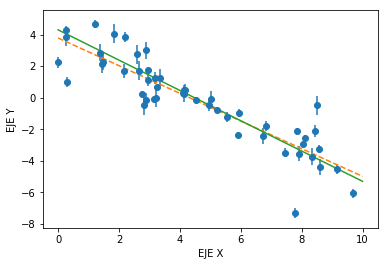

In [17]:
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(x2,y2, "--")
plt.plot(x1,y1, "-")
plt.xlabel("EJE X")
plt.ylabel("EJE Y")

trazados como una línea discontinua.

## Estimación de máxima probabilidad 

No hay una generalización de mínimos cuadrados que admita un modelo como el que sabemos que es verdadero. En su lugar, debemos escribir la función de probabilidad y optimizarla numéricamente. En notación matemática, la función de probabilidad correcta es:

$\ [\ ln \, p (y \, | \, x, \ sigma, m, b, f) = - \ frac {1} {2} \ sum_n \ left [\ frac {(y_n-m \, x_n -b) ^ 2} {s_n ^ 2} + \ ln \ left (2 \ pi \, s_n ^ 2 \ right) \ right] \]$

donde:

$\ [s_n ^ 2 = \ sigma_n ^ 2 + f ^ 2 \, (m \, x_n + b) ^ 2 \ quad. \]$

Esta función de probabilidad es simplemente una gaussiana en la que la variación está subestimada por alguna cantidad fraccionaria: f .

In [18]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [19]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [20]:
y3 = m_ml * x2 + b_ml

Text(0,0.5,'EJE Y')

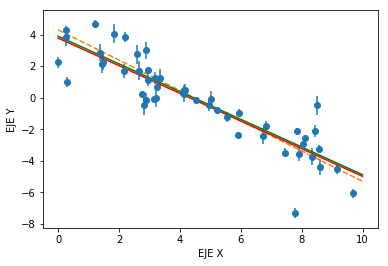

In [26]:
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(x1,y1, "--")
plt.plot(x2,y2, "-", color = 'r')
plt.plot(x2,y3, "-", color = 'g')
plt.xlabel("EJE X")
plt.ylabel("EJE Y")

## Marginalización y estimación de incertidumbre 

Vale la pena comentar que una razón común para usar MCMC es que podemos marginar algunos "parámetros de molestia" y encontrar una estimación de la Función de probabilidad posterior (la distribución de parámetros que es consistente con su conjunto de datos) para otros. MCMC permite hacer ambas cosas a la vez. Debemos comenzar escribiendo la función de probabilidad posterior (hasta una constante):

$\ [p (m, b, f \, | \, x, y, \ sigma) \ propto p (m, b, f) \, p (y \, | \, x, \ sigma, m, b, f) \ quad. ]$

donde:

$\ [p (y \, | \, x, \ sigma, m, b, f) \]$

es la funcion likelihood y la funcion "prior" es:

$  p  (m, b, f) $ 

Definimos la funcion log-prior y log-probabilidad:

In [28]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [29]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Después de toda esta configuración, es fácil muestrear esta distribución usando emcee . Comenzaremos inicializando a los caminantes en una pequeña bola gaussiana alrededor del resultado de máxima probabilidad (he descubierto que esto suele ser una muy buena inicialización en la mayoría de los casos):

In [30]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

Entonces, podemos configurar la muestra:

In [31]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

y ejecutar el MCMC durante 500 pasos a partir de la pequeña bola definida anteriormente:

In [33]:
sampler.run_mcmc(pos, 500)

(array([[-0.86766372,  3.86127993, -0.70856675],
        [-0.99124698,  4.17659997, -0.50947163],
        [-0.80090592,  3.76112117, -0.50532634],
        [-0.85123362,  3.67835699, -0.78553494],
        [-0.7854426 ,  3.49144612, -0.53806901],
        [-0.98297184,  4.33235619, -0.59538933],
        [-0.77788255,  3.60818192, -0.50534397],
        [-0.96295358,  4.31786634, -0.65197955],
        [-0.84579624,  3.61541921, -0.52497054],
        [-1.01534949,  4.52559804, -0.75639177],
        [-0.84224371,  3.77002149, -0.42388383],
        [-0.82796856,  3.62922535, -0.49837028],
        [-0.77295493,  3.59056501, -0.44863882],
        [-0.75928478,  3.31560901, -0.42836239],
        [-0.77223147,  3.32056239, -0.61463145],
        [-0.89648858,  4.05916803, -0.53470358],
        [-0.82104981,  3.76002214, -0.60427453],
        [-0.79715481,  3.64392747, -0.54458483],
        [-0.86941376,  3.9521412 , -0.64741641],
        [-0.92064718,  3.94865964, -0.38520402],
        [-0.95920566

Echemos un vistazo a lo que ha hecho la muestra. La mejor manera de ver esto es mirar las series temporales de los parámetros en la cadena. El objeto de sampler ahora tiene un atributo llamado chain que es una matriz con la forma (100, 500, 3) proporciona los valores de los parámetros para cada caminante en cada paso de la cadena. La siguiente figura muestra las posiciones de cada caminante en función del número de pasos en la cadena:

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


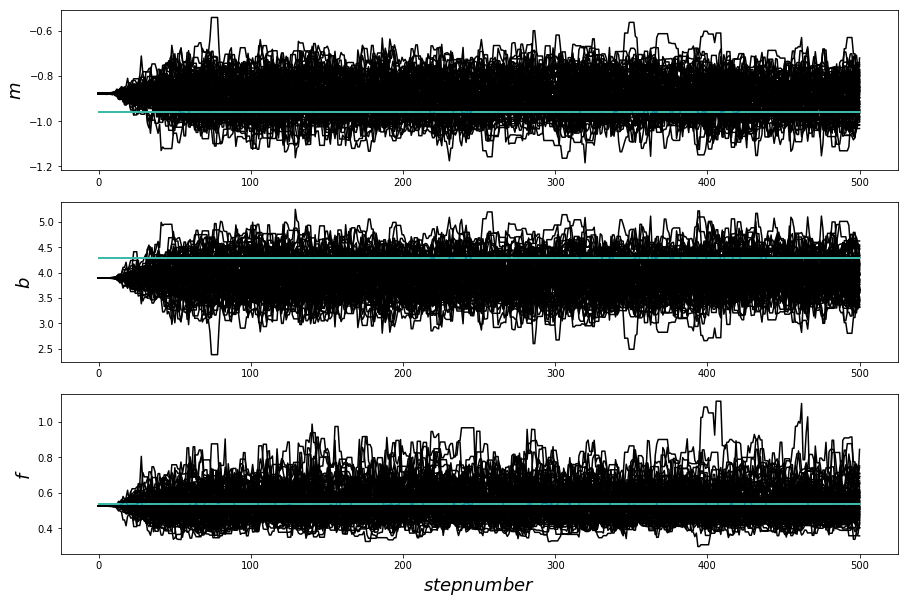

In [34]:
x_g = np.linspace(0.0, 500, 500)
y_m = m_true*np.ones(500)
y_b = b_true*np.ones(500)
y_f = f_true*np.ones(500)
plt.figure(figsize=(15,10))
for i in range(nwalkers):
    plt.subplot(3, 1, 1)
    plt.plot(x_g, sampler.chain[i,:,0], '-k')
    plt.plot(x_g, y_m, '-')
    plt.ylabel('$m$',fontsize = 18)

    plt.subplot(3, 1, 2)
    plt.plot(x_g, sampler.chain[i,:,1], '-k')
    plt.plot(x_g, y_b, '-')
    plt.ylabel('$b$',fontsize = 18)

    plt.subplot(3, 1, 3)
    plt.plot(x_g, np.exp(sampler.chain[i,:,2]), '-k')
    plt.plot(x_g, y_f, '-')
    plt.xlabel('$stepnumber$',fontsize = 18)
    plt.ylabel('$f$',fontsize = 18)
plt.show()



Los valores reales de los parámetros se indican como líneas grises en la parte superior de las muestras. Como se mencionó anteriormente, los caminantes comienzan en pequeñas distribuciones alrededor de los valores de máxima verosimilitud y luego vagan rápidamente y comienzan a explorar la distribución posterior completa. De hecho, después de menos de 50 pasos, las muestras parecen bastante bien "quemadas". Esa es una declaración difícil de hacer cuantitativamente, pero por ahora, simplemente la aceptaremos y descartaremos los 50 pasos iniciales y aplanaremos la cadena para que tengamos una lista plana de muestras:

In [62]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

## Resultados

Ahora que tenemos esta lista de muestras, hagamos una de las gráficas más útiles que puede hacer con sus resultados de MCMC: una gráfica de esquina:

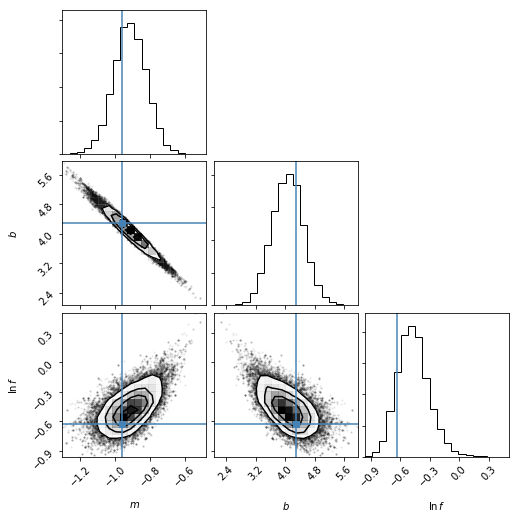

In [63]:
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

La gráfica de la esquina muestra todas las proyecciones unidimensionales y bidimensionales de las distribuciones de probabilidad posteriores de sus parámetros. Esto es útil porque demuestra rápidamente todas las covarianzas entre los parámetros. Además, la forma en que encuentre la distribución marginal para un parámetro o conjunto de parámetros utilizando los resultados de la cadena MCMC es proyectar las muestras en ese plano y luego hacer un histograma de N dimensiones. Eso significa que la gráfica de la esquina muestra la distribución marginalizada para cada parámetro independientemente en los histogramas a lo largo de la diagonal y luego las distribuciones bidimensionales marginadas en los otros paneles.

Otra gráfica de diagnóstico es la proyección de sus resultados en el espacio de los datos observados. Para hacer esto, puede elegir algunas muestras (digamos 100 en este caso) de la cadena y trazarlas sobre los puntos de datos: 

<ErrorbarContainer object of 3 artists>

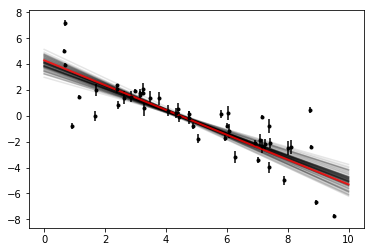

In [64]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")

Esto nos deja con una pregunta: ¿qué números deben ir en el resumen? Hay algunas opciones diferentes para esto, pero mi favorito es citar las incertidumbres basadas en los percentiles 16, 50 y 84 de las muestras en las distribuciones marginadas. Para calcular estos números para este ejemplo, ejecutarías:

In [66]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))